#  Segmentation d'Images de Fleurs avec K-means

**Projet**: Segmentation automatique de fleurs par clustering de couleurs

**Dataset**: Flowers Recognition (4242 images)

**Auteurs**: Driouch Mohamed Amine, Belkamel Mouad, El Faghloumi Khalid

---


##  1. Installation et Imports

In [19]:
# Installation des librairies nécessaires
!pip install opencv-python-headless scikit-image -q

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Images
from skimage import io, color, filters
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports terminés avec succès!")

✅ Imports terminés avec succès!


##  2. Upload et Chargement du Dataset

In [ ]:
# Upload du fichier ZIP depuis ton ordinateur
from google.colab import files

print(" Upload ton fichier 'flowers.zip' maintenant...")
uploaded = files.upload()
print(" Upload terminé!")

In [4]:
# Extraction du ZIP
zip_file = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')

print("✅ Dataset extrait!")
print("\n📁 Structure du dataset:")
!ls -R dataset/

✅ Dataset extrait!

📁 Structure du dataset:
dataset/:
flowers

dataset/flowers:
daisy  dandelion  rose	sunflower  tulip

dataset/flowers/daisy:
100080576_f52e8ee070_n.jpg    34571214621_f655295459_n.jpg
10140303196_b88d3d6cec.jpg    34585331601_837dbe5254_n.jpg
10172379554_b296050f82_n.jpg  34585995071_13e07140d8_n.jpg
10172567486_2748826a8b.jpg    34590677231_0ed33ccd55_n.jpg
10172636503_21bededa75_n.jpg  34591991761_16fc5c9c00_n.jpg
102841525_bd6628ae3c.jpg      34602180741_cf2f671ba5_n.jpg
10300722094_28fa978807_n.jpg  34611565966_9de274f987_n.jpg
1031799732_e7f4008c03.jpg     34613530216_26cf037012_n.jpg
10391248763_1d16681106_n.jpg  3463313493_9497aa47e5_n.jpg
10437754174_22ec990b77_m.jpg  34637394046_f85541735d_n.jpg
10437770546_8bb6f7bdd3_m.jpg  34637970155_a2b917077c_n.jpg
10437929963_bc13eebe0c.jpg    34638378196_216d5bbc2e_n.jpg
10466290366_cc72e33532.jpg    34643914016_2e659d6e82_n.jpg
10466558316_a7198b87e2.jpg    34652819496_0b6f758986_n.jpg
10555749515_13a12a026e.jpg    3

In [21]:
# Configuration des chemins
DATA_PATH = 'dataset/flowers'
CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Vérification
print(f" Classes de fleurs: {CLASSES}")
print(f"\n Nombre d'images par classe:")

for flower in CLASSES:
    path = os.path.join(DATA_PATH, flower)
    num_images = len(os.listdir(path))
    print(f"  - {flower.capitalize()}: {num_images} images")

 Classes de fleurs: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

 Nombre d'images par classe:
  - Daisy: 764 images
  - Dandelion: 1052 images
  - Rose: 784 images
  - Sunflower: 733 images
  - Tulip: 984 images


## 🔍 3. Exploration des Données

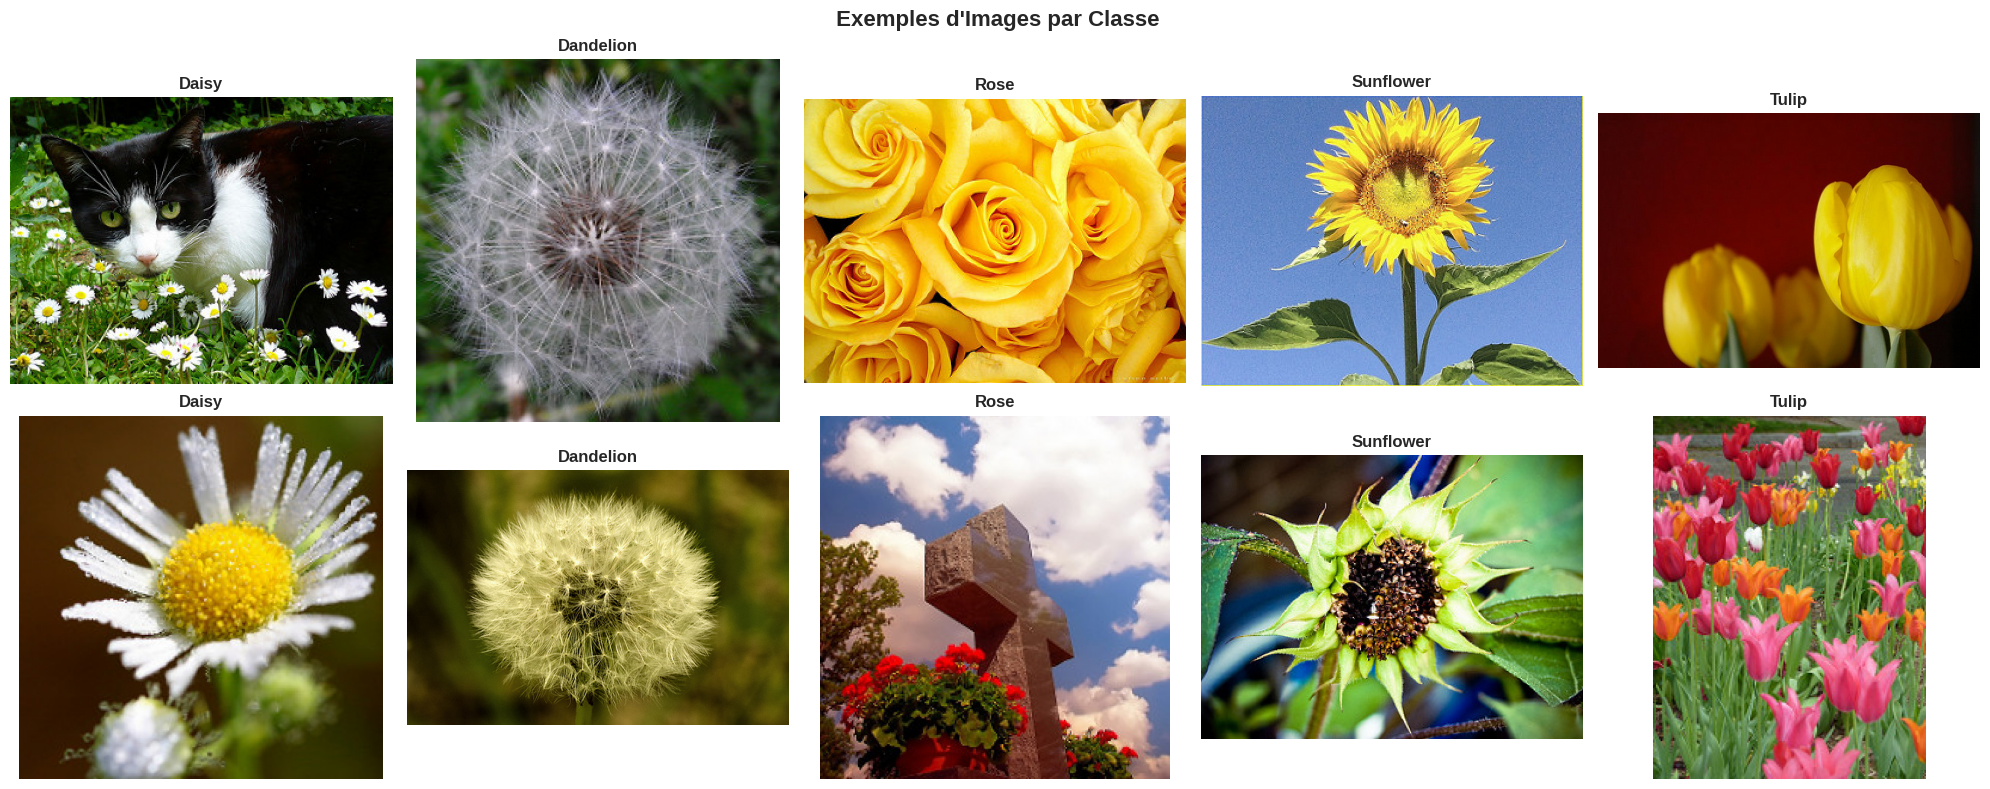

In [22]:
# Visualisation d'exemples d'images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(' Exemples d\'Images par Classe', fontsize=16, fontweight='bold')

for idx, flower in enumerate(CLASSES):
    path = os.path.join(DATA_PATH, flower)
    images = os.listdir(path)[:2]  # 2 images par classe

    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i, idx].imshow(img)
        axes[i, idx].set_title(flower.capitalize(), fontweight='bold')
        axes[i, idx].axis('off')

plt.tight_layout()
plt.show()

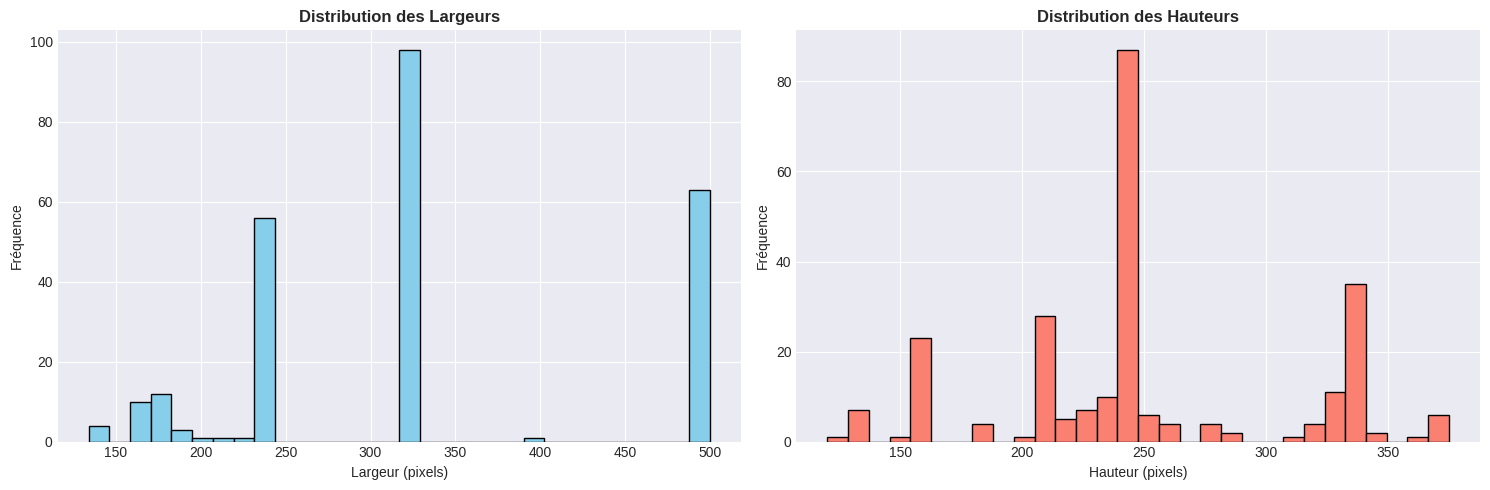

 Dimensions moyennes: 329x248 pixels


In [23]:
# Analyse des dimensions d'images
dimensions = []

for flower in CLASSES:
    path = os.path.join(DATA_PATH, flower)
    for img_name in os.listdir(path)[:50]:  # Échantillon de 50 images
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            dimensions.append({
                'width': img.shape[1],
                'height': img.shape[0],
                'class': flower
            })

df_dims = pd.DataFrame(dimensions)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme des largeurs
axes[0].hist(df_dims['width'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution des Largeurs', fontweight='bold')
axes[0].set_xlabel('Largeur (pixels)')
axes[0].set_ylabel('Fréquence')

# Histogramme des hauteurs
axes[1].hist(df_dims['height'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Distribution des Hauteurs', fontweight='bold')
axes[1].set_xlabel('Hauteur (pixels)')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

print(f" Dimensions moyennes: {df_dims['width'].mean():.0f}x{df_dims['height'].mean():.0f} pixels")

##  4. Fonctions de Segmentation avec K-means

In [24]:
def preprocess_image(image_path, target_size=(256, 256)):
    """
    Prétraitement de l'image:
    - Chargement
    - Redimensionnement
    - Conversion RGB
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img


def segment_image_kmeans(img, n_clusters=5, random_state=42):
    """
    Segmentation d'image avec K-means:
    - Reshape de l'image en vecteur de pixels
    - Application de K-means
    - Reconstruction de l'image segmentée

    Returns:
    - segmented_img: Image segmentée avec couleurs des clusters
    - labels: Labels de cluster pour chaque pixel
    - model: Modèle K-means entraîné
    """
    # Sauvegarde de la forme originale
    original_shape = img.shape

    # Reshape en 2D (pixels x couleurs RGB)
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(pixel_values)

    # Remplacement de chaque pixel par la couleur de son cluster
    centers = np.uint8(kmeans.cluster_centers_)
    segmented_image = centers[labels.flatten()]

    # Reshape vers la forme originale
    segmented_image = segmented_image.reshape(original_shape)

    return segmented_image, labels.reshape(original_shape[:2]), kmeans


def extract_largest_segment(img, labels):
    """
    Extrait le plus grand segment (souvent la fleur):
    - Identifie le cluster le plus fréquent
    - Crée un masque binaire
    - Applique le masque sur l'image
    """
    # Trouver le label le plus fréquent (généralement la fleur)
    unique, counts = np.unique(labels, return_counts=True)
    # On évite le fond (souvent le plus grand cluster), on prend le 2ème
    sorted_indices = np.argsort(counts)[::-1]
    main_label = unique[sorted_indices[1]] if len(unique) > 1 else unique[0]

    # Créer un masque pour ce segment
    mask = (labels == main_label).astype(np.uint8) * 255

    # Appliquer le masque
    result = cv2.bitwise_and(img, img, mask=mask)

    return result, mask


print(" Fonctions de segmentation créées!")

 Fonctions de segmentation créées!


## 🧠 5. Entraînement et Optimisation du Modèle

 Recherche du nombre optimal de clusters...


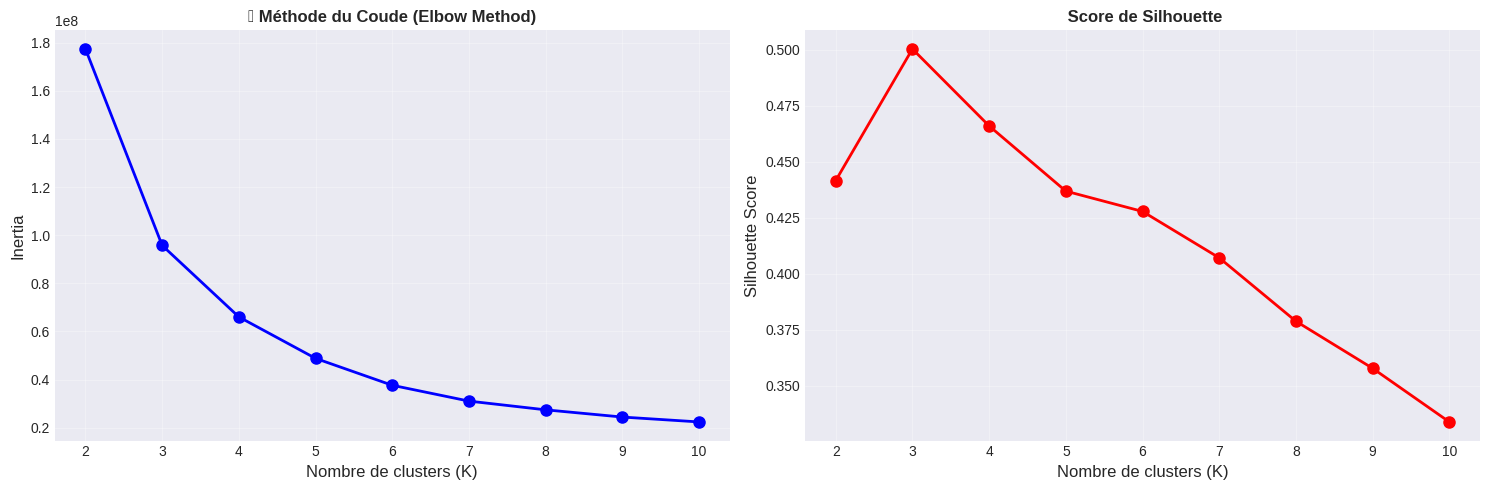


 Nombre optimal de clusters recommandé: K = 3
   Silhouette Score: 0.5003


In [25]:
# Test avec différents nombres de clusters pour trouver l'optimal
def find_optimal_clusters(img, max_k=10):
    """
    Trouve le nombre optimal de clusters avec:
    - Méthode du coude (Inertia)
    - Silhouette Score
    """
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pixel_values)

        inertias.append(kmeans.inertia_)

        # Silhouette score (échantillon pour rapidité)
        sample_size = min(5000, len(pixel_values))
        indices = np.random.choice(len(pixel_values), sample_size, replace=False)
        score = silhouette_score(pixel_values[indices], labels[indices])
        silhouette_scores.append(score)

    return list(k_range), inertias, silhouette_scores


# Test sur une image exemple
sample_flower = 'rose'
sample_path = os.path.join(DATA_PATH, sample_flower)
sample_img_name = os.listdir(sample_path)[0]
sample_img_path = os.path.join(sample_path, sample_img_name)

sample_img = preprocess_image(sample_img_path)

print(" Recherche du nombre optimal de clusters...")
k_values, inertias, silhouette_scores = find_optimal_clusters(sample_img, max_k=10)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Méthode du coude
axes[0].plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('📊 Méthode du Coude (Elbow Method)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title(' Score de Silhouette', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recommandation
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\n Nombre optimal de clusters recommandé: K = {best_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.4f}")

 Application de la segmentation avec K = 5...



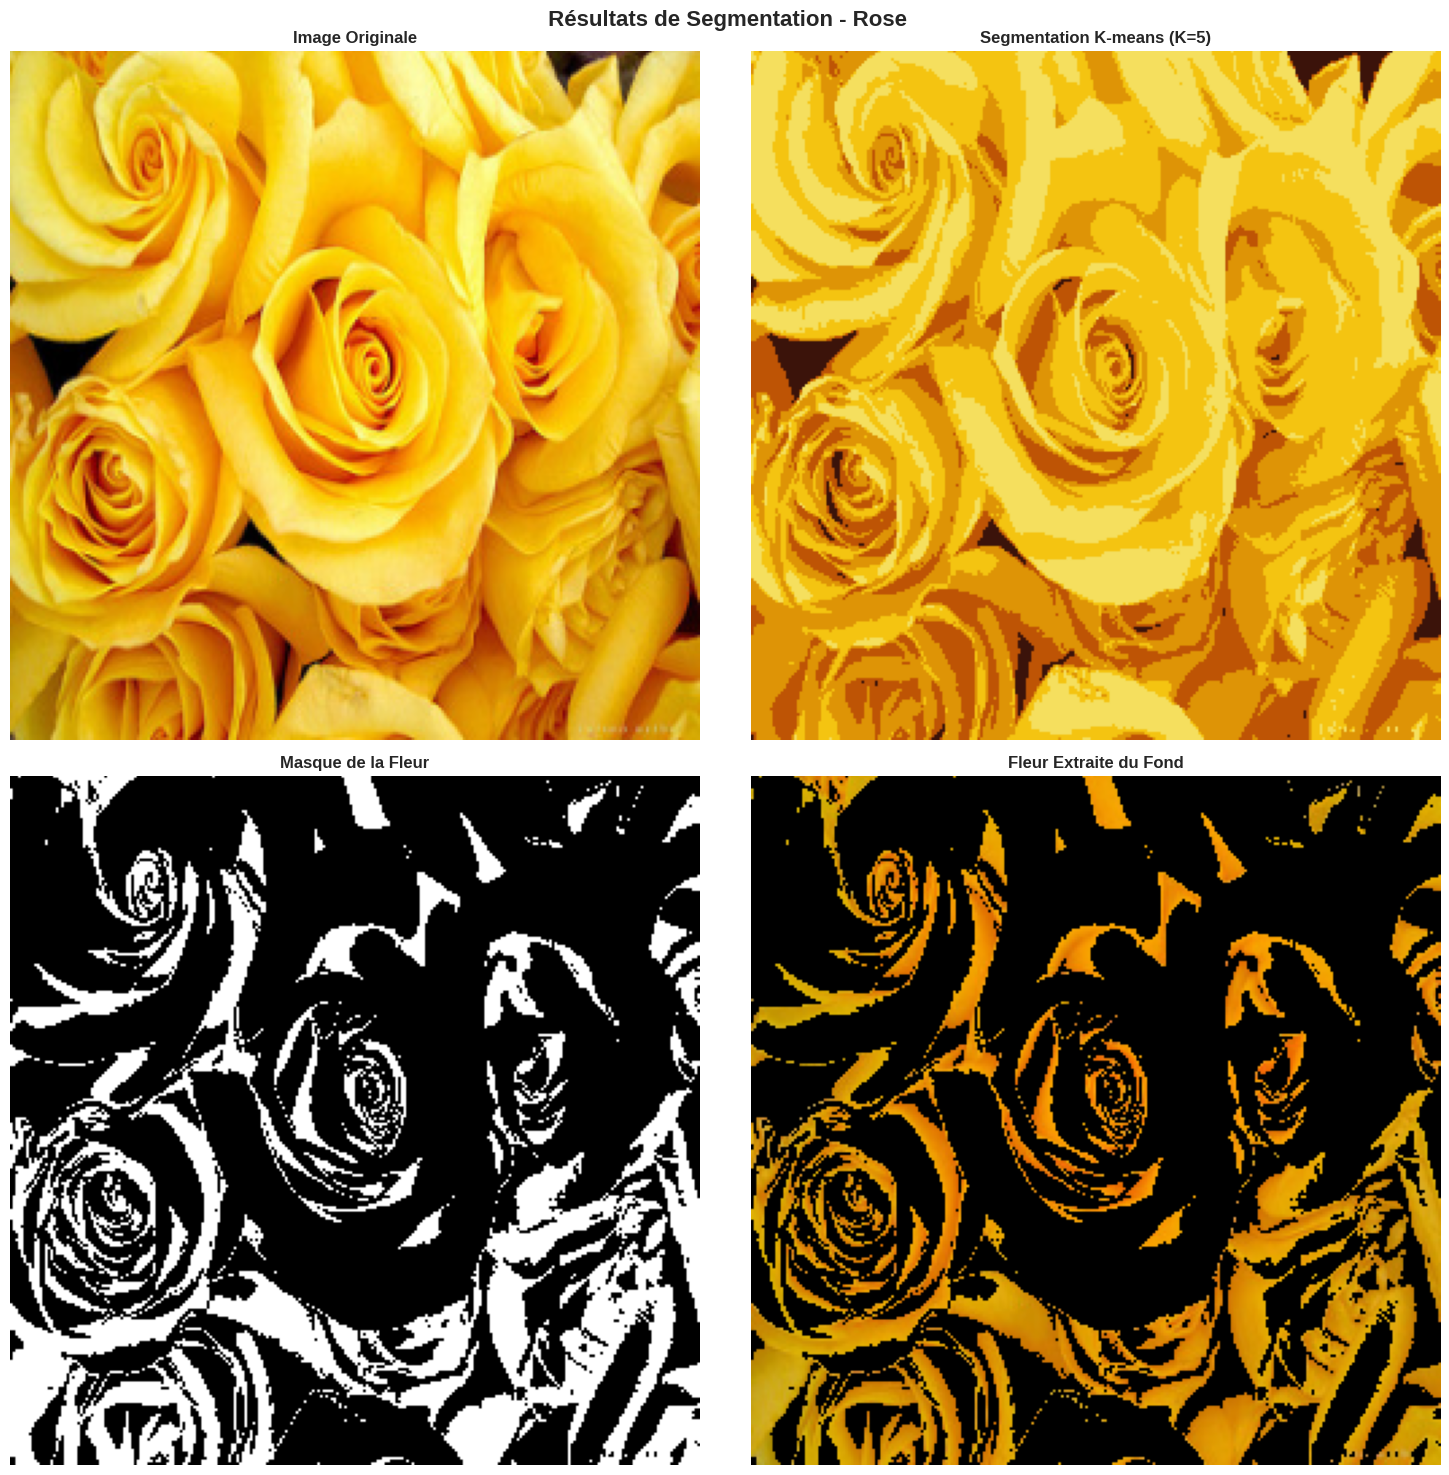

In [26]:
# Application de la segmentation avec K optimal
OPTIMAL_K = 5  # Tu peux ajuster selon les résultats ci-dessus

print(f" Application de la segmentation avec K = {OPTIMAL_K}...\n")

# Segmentation
segmented_img, labels, kmeans_model = segment_image_kmeans(sample_img, n_clusters=OPTIMAL_K)

# Extraction du plus grand segment
extracted_flower, mask = extract_largest_segment(sample_img, labels)

# Visualisation des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f' Résultats de Segmentation - {sample_flower.capitalize()}', fontsize=16, fontweight='bold')

# Image originale
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title('Image Originale', fontweight='bold')
axes[0, 0].axis('off')

# Image segmentée
axes[0, 1].imshow(segmented_img)
axes[0, 1].set_title(f'Segmentation K-means (K={OPTIMAL_K})', fontweight='bold')
axes[0, 1].axis('off')

# Masque
axes[1, 0].imshow(mask, cmap='gray')
axes[1, 0].set_title('Masque de la Fleur', fontweight='bold')
axes[1, 0].axis('off')

# Fleur extraite
axes[1, 1].imshow(extracted_flower)
axes[1, 1].set_title('Fleur Extraite du Fond', fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

##  6. Métriques d'Évaluation

In [28]:
def calculate_segmentation_metrics(img, labels, kmeans_model):
    """
    Calcule plusieurs métriques pour évaluer la qualité de la segmentation:
    - Silhouette Score (cohésion des clusters)
    - Inertia (compacité des clusters)
    - Davies-Bouldin Index (séparation des clusters)
    - Nombre de segments
    """
    pixel_values = img.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Échantillonnage pour rapidité
    sample_size = min(10000, len(pixel_values))
    indices = np.random.choice(len(pixel_values), sample_size, replace=False)

    labels_flat = labels.flatten()

    metrics = {
        'silhouette_score': silhouette_score(pixel_values[indices], labels_flat[indices]),
        'inertia': kmeans_model.inertia_,
        'davies_bouldin': davies_bouldin_score(pixel_values[indices], labels_flat[indices]),
        'n_clusters': len(np.unique(labels_flat)),
        'cluster_sizes': dict(zip(*np.unique(labels_flat, return_counts=True)))
    }

    return metrics


# Calcul des métriques
metrics = calculate_segmentation_metrics(sample_img, labels, kmeans_model)

print(" MÉTRIQUES DE SEGMENTATION")
print("="*50)
print(f"\n Silhouette Score: {metrics['silhouette_score']:.4f}")
print(f"   → Score entre -1 et 1 (plus proche de 1 = meilleur)")
print(f"\n Inertia: {metrics['inertia']:,.2f}")
print(f"   → Somme des distances au centroïde (plus bas = meilleur)")
print(f"\n Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
print(f"   → Plus proche de 0 = meilleure séparation des clusters")
print(f"\n Nombre de clusters: {metrics['n_clusters']}")

print(f"\n Taille des segments (en pixels):")
for cluster_id, size in sorted(metrics['cluster_sizes'].items()):
    percentage = (size / (sample_img.shape[0] * sample_img.shape[1])) * 100
    print(f"   Segment {cluster_id}: {size:,} pixels ({percentage:.2f}%)")

 MÉTRIQUES DE SEGMENTATION

 Silhouette Score: 0.4396
   → Score entre -1 et 1 (plus proche de 1 = meilleur)

 Inertia: 48,839,416.00
   → Somme des distances au centroïde (plus bas = meilleur)

 Davies-Bouldin Index: 0.6929
   → Plus proche de 0 = meilleure séparation des clusters

 Nombre de clusters: 5

 Taille des segments (en pixels):
   Segment 0: 18,239 pixels (27.83%)
   Segment 1: 8,301 pixels (12.67%)
   Segment 2: 14,773 pixels (22.54%)
   Segment 3: 1,184 pixels (1.81%)
   Segment 4: 23,039 pixels (35.15%)


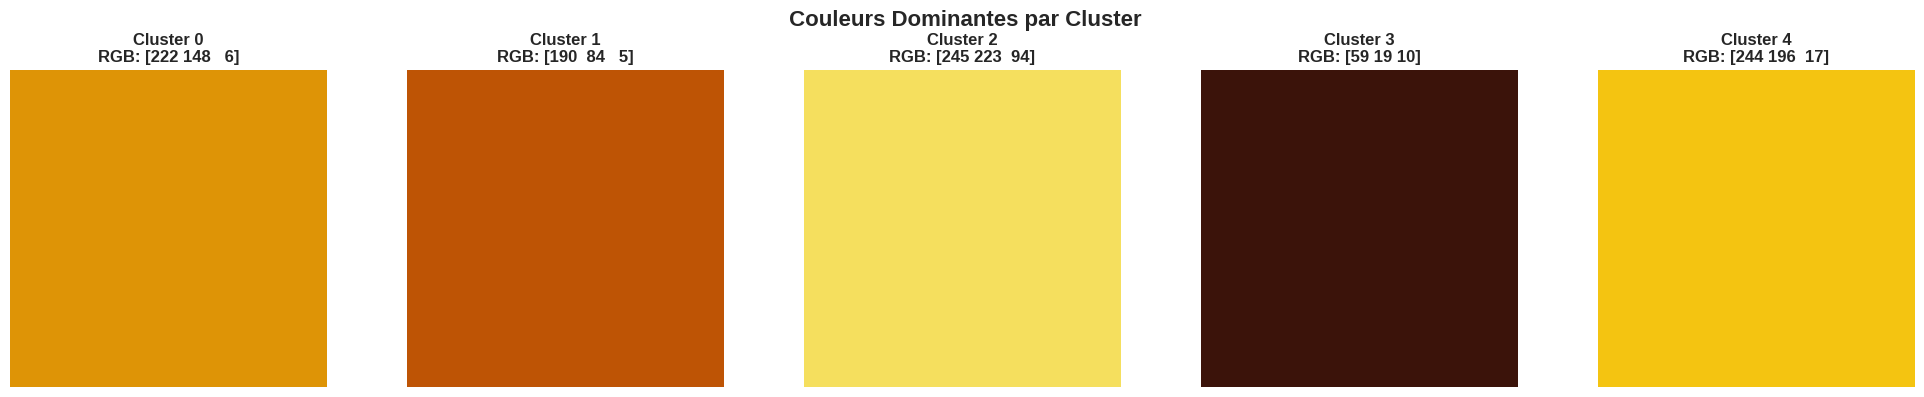

In [29]:
# Visualisation de la distribution des couleurs dans chaque cluster
fig, axes = plt.subplots(1, OPTIMAL_K, figsize=(20, 4))
fig.suptitle(' Couleurs Dominantes par Cluster', fontsize=16, fontweight='bold')

centers = kmeans_model.cluster_centers_.astype(int)

for i in range(OPTIMAL_K):
    # Créer un carré de couleur pour chaque centre
    color_square = np.ones((100, 100, 3), dtype=np.uint8)
    color_square[:, :] = centers[i]

    axes[i].imshow(color_square)
    axes[i].set_title(f'Cluster {i}\nRGB: {centers[i]}', fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

##  7. Application sur Plusieurs Images

 Segmentation de plusieurs images en cours...
 10 images segmentées avec succès!



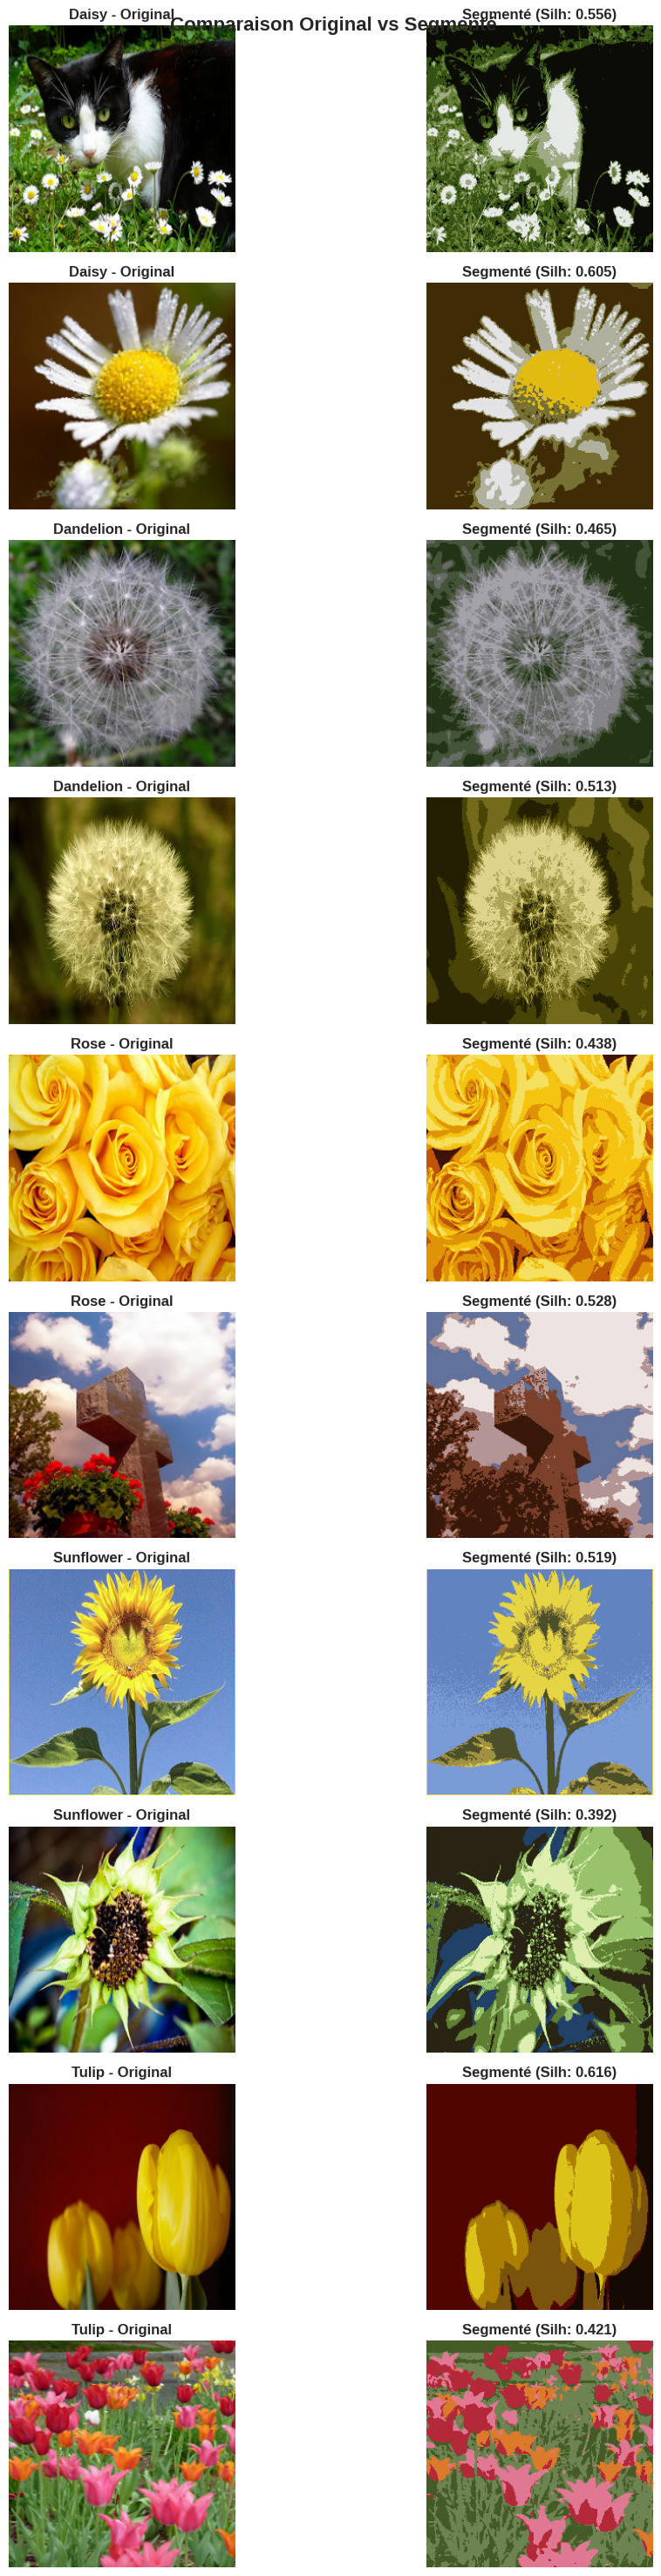

In [31]:
# Segmentation de plusieurs images pour validation
def segment_multiple_images(n_samples=3):
    """
    Segmente plusieurs images de différentes classes
    """
    results = []

    for flower in CLASSES:
        path = os.path.join(DATA_PATH, flower)
        img_files = os.listdir(path)[:n_samples]

        for img_name in img_files:
            img_path = os.path.join(path, img_name)

            # Preprocessing
            img = preprocess_image(img_path)

            # Segmentation
            seg_img, lbls, model = segment_image_kmeans(img, n_clusters=OPTIMAL_K)

            # Métriques
            mtrcs = calculate_segmentation_metrics(img, lbls, model)

            results.append({
                'class': flower,
                'original': img,
                'segmented': seg_img,
                'labels': lbls,
                'silhouette': mtrcs['silhouette_score'],
                'inertia': mtrcs['inertia'],
                'davies_bouldin': mtrcs['davies_bouldin']
            })

    return results


print(" Segmentation de plusieurs images en cours...")
multi_results = segment_multiple_images(n_samples=2)
print(f" {len(multi_results)} images segmentées avec succès!\n")

# Visualisation
n_display = min(10, len(multi_results))
fig, axes = plt.subplots(n_display, 2, figsize=(12, n_display * 3))
fig.suptitle(' Comparaison Original vs Segmenté', fontsize=16, fontweight='bold')

for i in range(n_display):
    result = multi_results[i]

    # Original
    axes[i, 0].imshow(result['original'])
    axes[i, 0].set_title(f"{result['class'].capitalize()} - Original", fontweight='bold')
    axes[i, 0].axis('off')

    # Segmenté
    axes[i, 1].imshow(result['segmented'])
    axes[i, 1].set_title(f"Segmenté (Silh: {result['silhouette']:.3f})", fontweight='bold')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Statistiques globales
df_results = pd.DataFrame([{
    'Classe': r['class'],
    'Silhouette Score': r['silhouette'],
    'Inertia': r['inertia'],
    'Davies-Bouldin': r['davies_bouldin']
} for r in multi_results])

print(" STATISTIQUES GLOBALES")
print("="*70)
print("\n" + df_results.groupby('Classe').mean().to_string())
print("\n" + "="*70)
print("\nMoyennes générales:")
print(df_results.describe().loc[['mean', 'std']].to_string())

 STATISTIQUES GLOBALES

           Silhouette Score     Inertia  Davies-Bouldin
Classe                                                 
daisy              0.580534  66248182.0        0.678538
dandelion          0.489122  31331412.0        0.635707
rose               0.483017  70490188.0        0.728448
sunflower          0.455239  99773008.0        0.824491
tulip              0.518711  69720454.0        0.735471


Moyennes générales:
      Silhouette Score       Inertia  Davies-Bouldin
mean          0.505325  6.751265e+07        0.720531
std           0.075750  3.589760e+07        0.100601


##  8. Sauvegarde du Modèle

In [33]:
# Sauvegarde du modèle et des configurations
model_data = {
    'model': kmeans_model,
    'optimal_k': OPTIMAL_K,
    'target_size': (256, 256),
    'classes': CLASSES,
    'metrics': metrics
}

# Sauvegarde avec pickle
with open('flower_segmentation_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(" Modèle sauvegardé dans 'flower_segmentation_model.pkl'")

# Téléchargement du modèle
files.download('flower_segmentation_model.pkl')
print(" Modèle téléchargé sur ton ordinateur!")

 Modèle sauvegardé dans 'flower_segmentation_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Modèle téléchargé sur ton ordinateur!


## 🎯 9. Fonction de Prédiction pour API

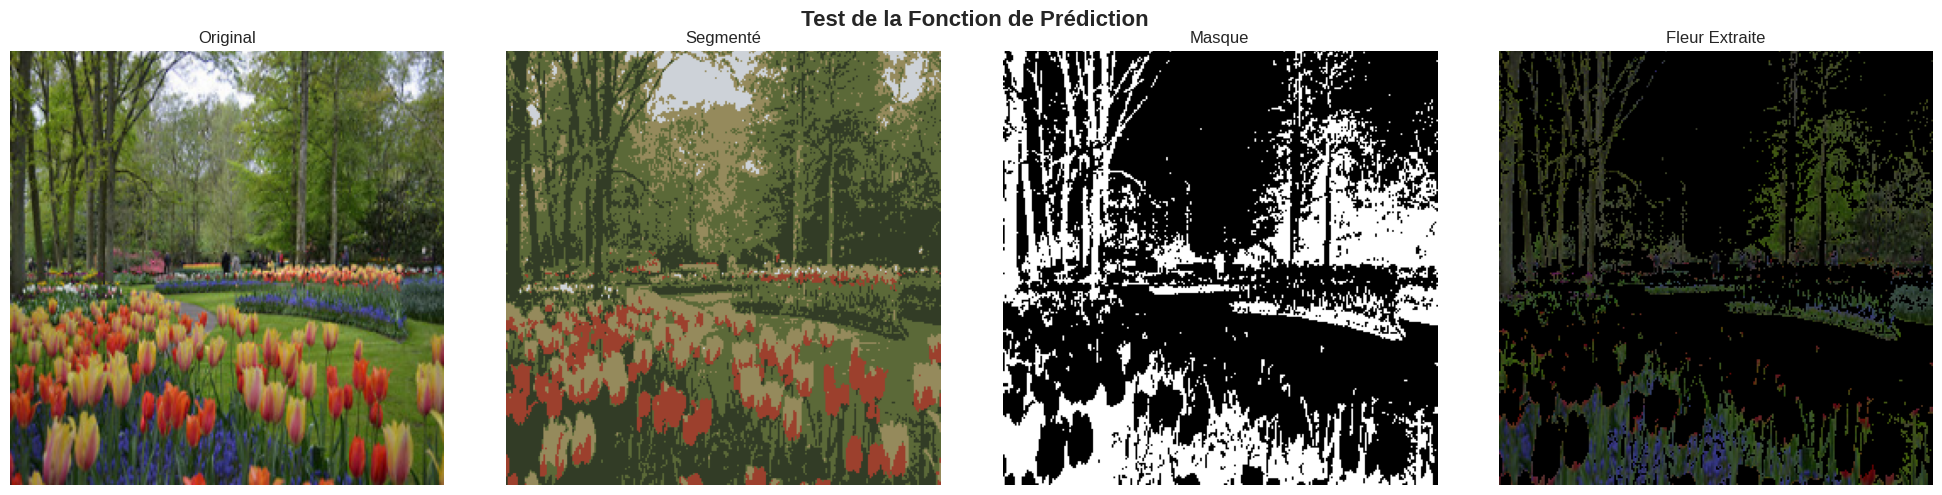


 Fonction de prédiction testée avec succès!
   Nombre de segments détectés: 5


In [34]:
def predict_segmentation(image_path, model_path='flower_segmentation_model.pkl'):
    """
    Fonction de prédiction pour l'API:
    - Charge le modèle
    - Segmente une nouvelle image
    - Retourne l'image segmentée et les métriques

    Cette fonction sera utilisée dans l'API Flask/FastAPI
    """
    # Chargement du modèle
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)

    # Preprocessing
    img = preprocess_image(image_path, target_size=model_data['target_size'])

    # Segmentation
    segmented_img, labels, _ = segment_image_kmeans(
        img,
        n_clusters=model_data['optimal_k']
    )

    # Extraction de la fleur
    extracted_flower, mask = extract_largest_segment(img, labels)

    return {
        'original': img,
        'segmented': segmented_img,
        'extracted': extracted_flower,
        'mask': mask,
        'n_segments': len(np.unique(labels))
    }


# Test de la fonction de prédiction
test_img_path = os.path.join(DATA_PATH, 'tulip', os.listdir(os.path.join(DATA_PATH, 'tulip'))[5])
prediction = predict_segmentation(test_img_path)

# Visualisation
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(' Test de la Fonction de Prédiction', fontsize=16, fontweight='bold')

axes[0].imshow(prediction['original'])
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(prediction['segmented'])
axes[1].set_title('Segmenté')
axes[1].axis('off')

axes[2].imshow(prediction['mask'], cmap='gray')
axes[2].set_title('Masque')
axes[2].axis('off')

axes[3].imshow(prediction['extracted'])
axes[3].set_title('Fleur Extraite')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"\n Fonction de prédiction testée avec succès!")
print(f"   Nombre de segments détectés: {prediction['n_segments']}")